In [2]:
# Main/Visualization Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ML Libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, classification_report, confusion_matrix
from sklearn.preprocessing import RobustScaler, OneHotEncoder, LabelEncoder

import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
data = pd.read_csv('PublicReleaseArrestDataUpdate.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 410682 entries, 0 to 410681
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   ARR_DISTRICT     406861 non-null  float64
 1   ARR_BEAT         406861 non-null  float64
 2   ARR_YEAR         410682 non-null  int64  
 3   ARR_MONTH        410682 non-null  int64  
 4   RACE_CODE_CD     410682 non-null  object 
 5   FBI_CODE         410591 non-null  object 
 6   STATUTE          410682 non-null  object 
 7   STAT_DESCR       410682 non-null  object 
 8   CHARGE_CLASS_CD  385661 non-null  object 
 9   CHARGE_TYPE_CD   309992 non-null  object 
dtypes: float64(2), int64(2), object(6)
memory usage: 31.3+ MB


In [4]:
# Since district and beat are identifiers, we should convert them from float numbers to integers to minimize confusion when analyzing data.

data[['ARR_DISTRICT','ARR_BEAT']] = data[['ARR_DISTRICT','ARR_BEAT']].fillna(0)
data['ARR_DISTRICT'] = data['ARR_DISTRICT'].apply(lambda x:int(x))
data['ARR_BEAT'] = data['ARR_BEAT'].apply(lambda x:int(x))
data.head()

,ARR_DISTRICT,ARR_BEAT,ARR_YEAR,ARR_MONTH,RACE_CODE_CD,FBI_CODE,STATUTE,STAT_DESCR,CHARGE_CLASS_CD,CHARGE_TYPE_CD
0,10,1033,2017,8,BLK,18,720 ILCS 570.0/407-B-1,MFG/DEL COCAINE/SCH/PUB HS/PK,X,F
1,9,923,2017,8,WWH,WRT,725 ILCS 225.0/13,FUGITIVE FROM JUSTICE - OUT OF STATE WARRANT,Z,NaN
2,10,1024,2017,8,BLK,WRT,725 ILCS 5.0/110-3,ISSUANCE OF WARRANT,Z,NaN
3,11,1112,2017,8,BLK,18,720 ILCS 570.0/407-B-1,MFG/DEL HEROIN/SCH/PUB HS/PK,X,F
4,25,2524,2017,8,WHI,18,720 ILCS 570.0/402-C,PCS - POSSESSION - POSS AMT CON SUB EXCEPT (A)(D),4,F


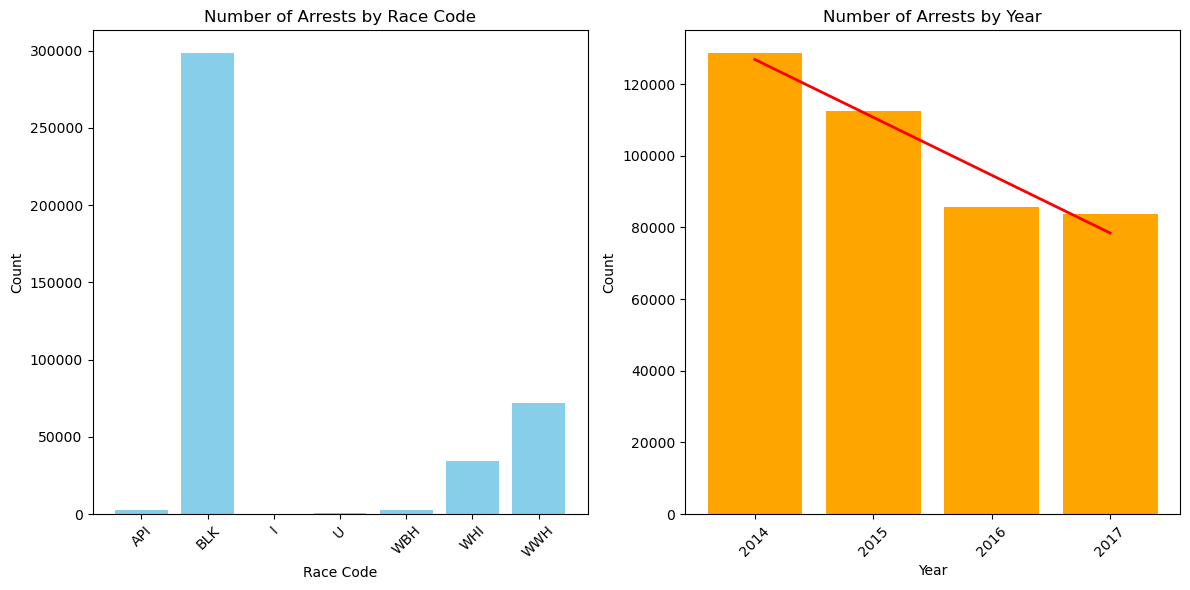

In [5]:
# Lets plot the count of these two groups using matplotlib.

race_group = data.groupby('RACE_CODE_CD').size()
year_group = data.groupby('ARR_YEAR').size()

# Plot for race group
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st plot
plt.bar(race_group.index, race_group.values, color='skyblue')
plt.title('Number of Arrests by Race Code')
plt.xlabel('Race Code')
plt.ylabel('Count')
plt.xticks(rotation=45)

# Plot for year group
coefficients = np.polyfit(year_group.index.values, year_group.values, 1)
trend_line = np.polyval(coefficients, year_group.index.values)

plt.subplot(1, 2, 2)  #2nd plot
plt.bar(year_group.index, year_group.values, color='orange')
plt.plot(year_group.index.values, trend_line, color='red', linewidth=2)
plt.title('Number of Arrests by Year')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45, ticks=year_group.index, labels=year_group.index.astype(int))


# Adjusting layout and showing the plot
plt.tight_layout()
plt.show()

### **Let's try to explain this data:**

#### Race Code: We can see that black Chicagoans (indicated with 'BLK') have a significantly higher arrest count compared to others. Part of this can be explained by how black or African-American citizens are the 2nd largest race group in the city. Looking at the chart below, we can see that they acccount for ~30% of the population, followed by Hispanic, which reflects on our data we plotted with White/Hispanic being the 2nd highest arrest count (indicated with 'WWH').
<iframe width="720px" height="720px" src="https://datausa.io/profile/geo/chicago-il/demographics/race_and_ethnicity?viz=false" frameborder="0" ></iframe>

#### Year: Statisically, Chicago's arrest rates have been decreasing over years. According to Illinois Policy, arrests are down 43% from 2013 to 2023. Our data only contains information about arrests between 2014-2017, but we can confirm that the arrest count has been decreasing over years.
<iframe width="720px" height="720px" src="https://www.datawrapper.de/_/MeMje/" frameborder="0" ></iframe>

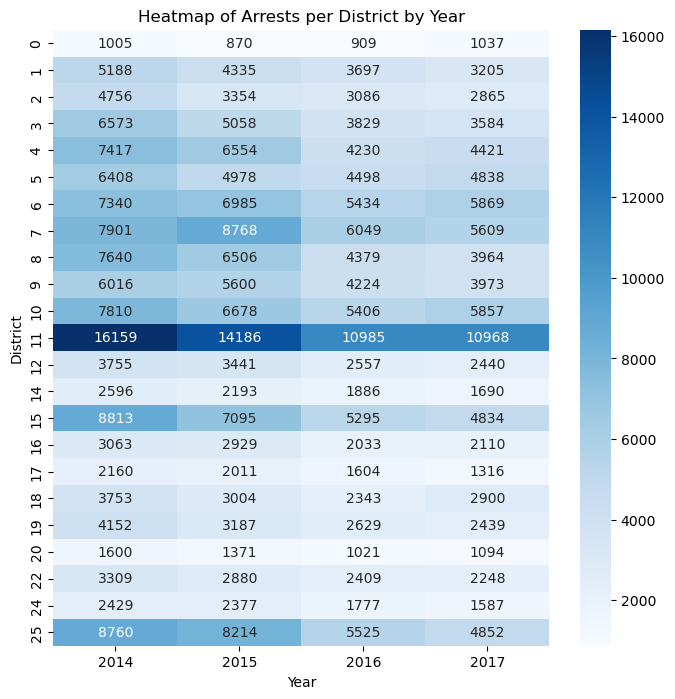

In [6]:
# Now lets plot arrests per district against years using Seaborn.

# Prepare the data: Pivot table to get counts of arrests by district and year
heatmap_data = data.pivot_table(index='ARR_DISTRICT', columns='ARR_YEAR', aggfunc='size', fill_value=0)

# Create the heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(heatmap_data, cmap='Blues', annot=True, fmt='d')

plt.title('Heatmap of Arrests per District by Year')
plt.xlabel('Year')
plt.ylabel('District')

# Show the plot
plt.show()

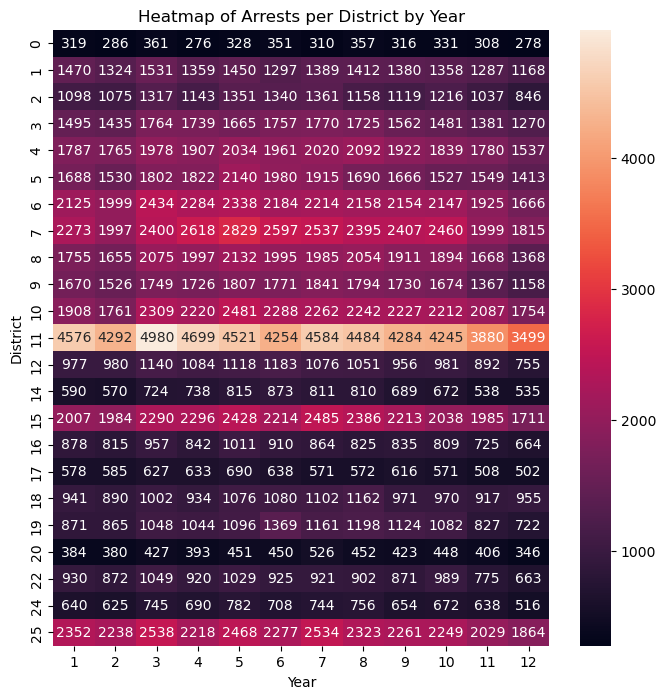

In [7]:
# Lets plot this again, but now with months instead of years, to see if any months see noticably higher arrest counts.

# Prepare the data: Pivot table to get counts of arrests by district and year
heatmap_data = data.pivot_table(index='ARR_DISTRICT', columns='ARR_MONTH', aggfunc='size', fill_value=0)

# Create the heatmap
plt.figure(figsize=(8, 8))
sns.heatmap(heatmap_data, annot=True, fmt='d')

plt.title('Heatmap of Arrests per District by Year')
plt.xlabel('Year')
plt.ylabel('District')

# Show the plot
plt.show()

# Looking at the data, no months in particular stand out.

### **Let's try to explain this data:**

#### District 11 Arrests: This district has almost 2 times the arrest count versus the next leading district. Looking at the population of District 11, we can see that the primary race/ethnicity is Black or African American, making up around 77% of District 11. We can relate this back to our bar chart of arrests by race code, and can confirm that this data is correlated, as our bar chart also displays a high amount of arrests coming from Black or African American Chicagoans.
(https://chirecoveryplan.com/geography/police-district-11/#race-ethnicity)

In [8]:
# Lets have a closer look at the data while we clean it up to use for machine learning.
unique_classes = data['CHARGE_CLASS_CD'].unique()
print(f'Unique Charge Classes: {unique_classes}')
data.groupby('CHARGE_CLASS_CD').size()

Unique Charge Classes: ['X' 'Z' '4' 'A' 'B' 'L' '2' '3' '1' 'M' 'C' 'P' nan 'U']


CHARGE_CLASS_CD
1      7483
2     14355
3     12359
4     49306
A    158417
B     34578
C     19284
L     40510
M      1222
P      3866
U       362
X     12684
Z     31235
dtype: int64

From the CPD website: "If F then X, 1, 2, 3, or 4; If M then A, B, or C; L = local ordinance violation; P = petty offense; U = business offense; Z = used for warrant arrests, criminal registration violations, and violations of court orders"

We can drop: 
- M as it is redundant (M - Misdemeanor[?])
- U as it cannot be used for predictive analysis (U - Unknown)
- nan because we cannot predict with blank data

In [9]:
# Dropping the irrelevant rows (based on 'CHARGE_CLASS_CD')
data.drop(data[data['CHARGE_CLASS_CD'].isin(['M', 'U'])].index,inplace=True)
data.dropna(subset='CHARGE_CLASS_CD',inplace=True)

unique_classes = data['CHARGE_CLASS_CD'].unique()
print(f'Unique Charge Classes: {unique_classes}')
data.groupby('CHARGE_CLASS_CD').size()

Unique Charge Classes: ['X' 'Z' '4' 'A' 'B' 'L' '2' '3' '1' 'C' 'P']


CHARGE_CLASS_CD
1      7483
2     14355
3     12359
4     49306
A    158417
B     34578
C     19284
L     40510
P      3866
X     12684
Z     31235
dtype: int64

In [10]:
unique_types = data['CHARGE_TYPE_CD'].unique()
print(f'Unqiue Types: {unique_types}')
data.groupby('CHARGE_TYPE_CD').size()

Unqiue Types: ['F' nan 'M' 'V' 'R' 'A']


CHARGE_TYPE_CD
A        14
F     96198
M    212319
R        22
V        68
dtype: int64

From the CPD website: "Code representing the level of the charge. 'M' wherein the charge was a Misdemeanor. 'F' wherein the charge was a Felony. Both in accordance with Illinois Compiled Statutes (ILCS)"


We can drop: A, R, V, and nan as the datapoints are too small for our purposes

In [11]:
data.drop(data[data['CHARGE_TYPE_CD'].isin(['V', 'R', 'A'])].index,inplace=True)
data.dropna(subset='CHARGE_TYPE_CD',inplace=True)

unique_types = data['CHARGE_TYPE_CD'].unique()
print(f'Unqiue Types: {unique_types}')
data.groupby('CHARGE_TYPE_CD').size()

Unqiue Types: ['F' 'M']


CHARGE_TYPE_CD
F     96198
M    212319
dtype: int64

In [12]:
print(f'''
      # of Unique Statutes: {data['STATUTE'].nunique()}, 
      # of Unique Statute Descriptions: {data['STAT_DESCR'].nunique()}
      # of Unique FBI Codes: {data['FBI_CODE'].nunique()}
      # of Unique Beats: {data['ARR_BEAT'].nunique()}
''')

# We can drop these columns, as there are simply too many categories to classify data on.
data.drop(columns=['STATUTE','STAT_DESCR','FBI_CODE','ARR_BEAT'], inplace=True)
data.info()


      # of Unique Statutes: 993, 
      # of Unique Statute Descriptions: 1468
      # of Unique FBI Codes: 28
      # of Unique Beats: 275

<class 'pandas.core.frame.DataFrame'>
Index: 308517 entries, 0 to 410681
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   ARR_DISTRICT     308517 non-null  int64 
 1   ARR_YEAR         308517 non-null  int64 
 2   ARR_MONTH        308517 non-null  int64 
 3   RACE_CODE_CD     308517 non-null  object
 4   CHARGE_CLASS_CD  308517 non-null  object
 5   CHARGE_TYPE_CD   308517 non-null  object
dtypes: int64(3), object(3)
memory usage: 16.5+ MB


#### **Now that our data is cleaned, we can train our models. We can deploy a linear regression model to predict how many arrests will occur depending on the district, year, and month using Sci-Kit.**


In [13]:
# We first need to aggregate the data to get the number of arrests per district, year, and month
data_aggregated = data.groupby(['ARR_DISTRICT', 'ARR_YEAR', 'ARR_MONTH']).size().reset_index(name='ARREST_COUNT')
data_aggregated.sort_values(by='ARREST_COUNT',ascending=False).head()

# We can begin by defining our independent values (X) and dependent values (y).
X = data_aggregated.drop(columns='ARREST_COUNT')
y = data_aggregated['ARREST_COUNT']

# We want to be able to view the performance of the model, so we can seperate our data into a training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=100)

In [14]:
# Now, we can create the model, standardize the data, and train the model
lr_model = LinearRegression()

scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

lr_model.fit(X_train,y_train)

LinearRegression()

MSE of Linear Regression model:
32462.389548922147

R2 Score of Linear Regression model:
0.09375465519117898



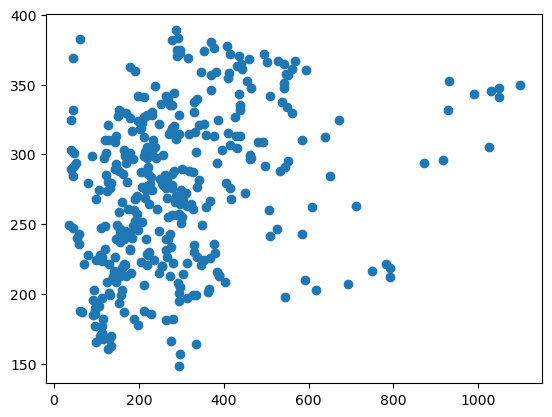

In [15]:
# We can also view the performance of our model, using the test data set we created earlier.
lr_prediction = lr_model.predict(X_test)

print(f'MSE of Linear Regression model:\n{mean_squared_error(y_test,lr_prediction)}\n')

print(f'R2 Score of Linear Regression model:\n{r2_score(y_test,lr_prediction)}\n')

# Our performance seems weak! We want a high R2 Score and a low MSE. Let's plot our expected values against our actual values.
plt.scatter(y_test,lr_prediction)

#### **We can see that our data is not best fit for a Linear Regression model. Let's try using a Random Forest intead.**

MSE of Random Forest Regressor:
1598.839571834681

R2 Score of Random Forest Regressor:
0.9553655495111444



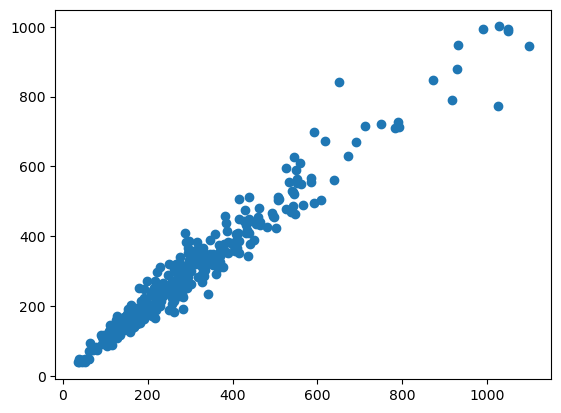

In [16]:
# We will repeat our fitting/training process, this time using a Random Forest Regressor instead of Linear Regression.
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10,random_state=100)

rf_model.fit(X_train,y_train)

rf_prediction = rf_model.predict(X_test)

print(f'MSE of Random Forest Regressor:\n{mean_squared_error(y_test,rf_prediction)}\n')

print(f'R2 Score of Random Forest Regressor:\n{r2_score(y_test,rf_prediction)}\n')

# Our scores seem significantly better! Let's visualize it to see how correlated our expected vs actual values look like.
plt.scatter(y_test,rf_prediction)

#### **Now that our model is much more optimized, we can predict outputs using custom data inputs.**

In [17]:
# We can use our model to predict our arrests based on district, year, and month
sample_data_one = pd.DataFrame({
    'ARR_DISTRICT':[2],
    'ARR_YEAR':[2018],
    'ARR_MONTH':[3]
})

sample_pred_one = int(rf_model.predict(scaler.transform(sample_data_one)))

print(f'District {sample_data_one['ARR_DISTRICT'][0]}, during year {sample_data_one['ARR_YEAR'][0]}, and month {sample_data_one['ARR_MONTH'][0]} is predicted to have {sample_pred_one} arrests.\n')

sample_data_two = pd.DataFrame({
    'ARR_DISTRICT':[11],
    'ARR_YEAR':[2020],
    'ARR_MONTH':[7]
})

sample_pred_two = int(rf_model.predict(scaler.transform(sample_data_two)))

print(f'District {sample_data_two['ARR_DISTRICT'][0]}, during year {sample_data_two['ARR_YEAR'][0]}, and month {sample_data_two['ARR_MONTH'][0]} is predicted to have {sample_pred_two} arrests.\n')


District 2, during year 2018, and month 3 is predicted to have 174 arrests.

District 11, during year 2020, and month 7 is predicted to have 671 arrests.



C:\Users\Vishvah\AppData\Local\Temp\ipykernel_25064\1696669460.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sample_pred_one = int(rf_model.predict(scaler.transform(sample_data_one)))
C:\Users\Vishvah\AppData\Local\Temp\ipykernel_25064\1696669460.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sample_pred_two = int(rf_model.predict(scaler.transform(sample_data_two)))


#### **We can also deploy a neural network, to predict whether the charge type for an arrest is either a felony (F) or a misdemeanour (M) based on provided features (i.e. district, year, month, race).**

In [18]:
# Since our neural network needs to have numeric inputs, and our race codes are strings, we can use OneHotEncoder to encode the race codes into sepeate columns with 1s and 0s.
oh_encoder = OneHotEncoder(sparse_output=False)

race_encoded = oh_encoder.fit_transform(data[['RACE_CODE_CD']])
race_encoded_df = pd.DataFrame(race_encoded, columns = oh_encoder.get_feature_names_out(['RACE_CODE_CD']))

nn_data = pd.concat([data[['ARR_DISTRICT','ARR_YEAR','ARR_MONTH','CHARGE_TYPE_CD']],race_encoded_df],axis=1)

nn_data.dropna(inplace=True)

nn_data.head()

,ARR_DISTRICT,ARR_YEAR,ARR_MONTH,CHARGE_TYPE_CD,RACE_CODE_CD_API,RACE_CODE_CD_BLK,RACE_CODE_CD_I,RACE_CODE_CD_U,RACE_CODE_CD_WBH,RACE_CODE_CD_WHI,RACE_CODE_CD_WWH
0,10.0,2017.0,8.0,F,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,11.0,2017.0,8.0,F,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,25.0,2017.0,8.0,F,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5,11.0,2017.0,9.0,M,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6,16.0,2017.0,9.0,M,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [19]:
# We can also use LabelEncoder to encode the charge type (our target variable).
l_encoder = LabelEncoder()

nn_data['CHARGE_TYPE_CD'] = l_encoder.fit_transform(nn_data['CHARGE_TYPE_CD'])

# We can defining our independent values (X) and dependent values (y).
X = nn_data.drop(columns='CHARGE_TYPE_CD')
y = nn_data['CHARGE_TYPE_CD']

# We can seperate our data into a training set and testing set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=100)

In [20]:
# Convert train and test data into PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

In [21]:
# We will define our neural network architecture via a class.

class Predictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(Predictor, self).__init__()
        
        # Define layers
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)  
        self.fc4 = nn.Linear(hidden_dim, output_dim)
        
        # Dropout layer
        self.dropout = nn.Dropout(p=.5)
        
        # Activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc4(x)
        return x


In [22]:
# Initializing model
input_dim = X_train.shape[1] # Number Of Training Columns
hidden_dim = 64
output_dim = len(l_encoder.classes_)

nn_model = Predictor(input_dim,hidden_dim,output_dim)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer (Adam, w/ 0.01 learning rate)
optimizer = optim.Adam(nn_model.parameters(), lr = 0.01)

In [23]:
# Training model 
epochs = 50
batch_size = 64

for epoch in range(epochs):

# Set model into training mode and reset all the gradients
    nn_model.train()
    optimizer.zero_grad()

# Forward pass
    layer_output = nn_model(X_train_tensor)
    loss = criterion(layer_output, y_train_tensor)

# Backpropagation and optimization
    loss.backward()
    optimizer.step()

    print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [1/50], Loss: 46.8497
Epoch [2/50], Loss: 79.8218
Epoch [3/50], Loss: 45.4067
Epoch [4/50], Loss: 19.5620
Epoch [5/50], Loss: 7.5570
Epoch [6/50], Loss: 3.9234
Epoch [7/50], Loss: 3.2916
Epoch [8/50], Loss: 2.8454
Epoch [9/50], Loss: 2.2113
Epoch [10/50], Loss: 1.7003
Epoch [11/50], Loss: 1.3636
Epoch [12/50], Loss: 1.1262
Epoch [13/50], Loss: 0.9724
Epoch [14/50], Loss: 0.8904
Epoch [15/50], Loss: 0.8357
Epoch [16/50], Loss: 0.7959
Epoch [17/50], Loss: 0.7664
Epoch [18/50], Loss: 0.7404
Epoch [19/50], Loss: 0.7197
Epoch [20/50], Loss: 0.7073
Epoch [21/50], Loss: 0.6967
Epoch [22/50], Loss: 0.6889
Epoch [23/50], Loss: 0.6826
Epoch [24/50], Loss: 0.6766
Epoch [25/50], Loss: 0.6718
Epoch [26/50], Loss: 0.6647
Epoch [27/50], Loss: 0.6618
Epoch [28/50], Loss: 0.6561
Epoch [29/50], Loss: 0.6524
Epoch [30/50], Loss: 0.6487
Epoch [31/50], Loss: 0.6458
Epoch [32/50], Loss: 0.6439
Epoch [33/50], Loss: 0.6412
Epoch [34/50], Loss: 0.6391
Epoch [35/50], Loss: 0.6373
Epoch [36/50], Loss: 0.63

In [24]:
# We can evaluate the model's performance now.
nn_model.eval()

with torch.no_grad():
    nn_prediction = nn_model(X_test_tensor)
    predicted = torch.max(nn_prediction, 1)[1]

    correct = (predicted == y_test_tensor).sum().item()
    total = y_test_tensor.size(0)
    accuracy = correct / total

print(f'Test Accuracy: {accuracy * 100:.2f}%')

Test Accuracy: 68.90%
